In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import random

In [2]:
books = pd.read_csv('../Books/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines = False, encoding='latin-1')
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Publisher', 'Year-Of-Publication'], axis=1, inplace=True)
ratings = pd.read_csv('../Books/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users = pd.read_csv('../Books/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines = False, encoding='latin-1')
users.drop(['Location'], axis = 1, inplace=True)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/IPython/core/inte

Clean up data; do we have ratings for books that are not in the book data? Which rating system will we use (implict, explict)? Are there Nans?

In [3]:
def compactBooks(book, ratings):
    #count entries with same name and same author
    bookgroups = book.groupby(["Book-Title", "Book-Author"])

    booksort = bookgroups.size().sort_values(ascending=False)
    for i, ind in enumerate(booksort.index):
        #look only at the ones with counts > 1
        if booksort.values[i] == 1:
            continue
        else:
            thisgroup = bookgroups.groups[ind[0], ind[1]]
            firstind = thisgroup[0]
            firstisbn = book['ISBN'][firstind]  #get isbn for book with this index
            #loop through others in groups
            for i in thisgroup[1:]:
                #change isbns in *ratings* of group to firstisbn
                copyisbn = book['ISBN'][i]
                ratingsOnCopy = np.where(ratings['ISBN']==copyisbn)
                ratings['ISBN'][ratingsOnCopy[0]] = firstisbn
                
                #drop row of book copy
                book.drop([i], inplace=True)
                
    return book, ratings
            

In [4]:
def cleanRatings(allratings, books):
    ratings_allbooks = allratings[allratings['ISBN'].isin(books['ISBN'])]
    ratings_implicit = ratings_allbooks[ratings_allbooks["Book-Rating"] == 0]
    ratings_explicit = ratings_allbooks[ratings_allbooks["Book-Rating"] != 0]
    
    ratings_implicit.drop_duplicates(subset=['ISBN', 'User-ID'], inplace=True)
    ratings_explicit.drop_duplicates(subset=['ISBN', 'User-ID'], inplace=True)
    
    ratings_implicit["Book-Rating"] = np.ones(len(ratings_implicit['Book-Rating']))
    
    return ratings_implicit, ratings_explicit

Make the dataset smaller, we don't need users that have rated few books or books with few ratings

Take only the books with more than 50 ratings and only the users who have rated at least 100 books

In [5]:
def reduceRates(rates, userLimit, bookLimit):
    count_users = rates['User-ID'].value_counts()
    count_books= rates['ISBN'].value_counts()
    
    fig, ax = plt.subplots(1,2)
    ax[0].hist(count_users.values, bins = int(np.max(count_users.values)/100))
    ax[0].set_yscale('log')
    ax[0].set_xlim(0, 3000)
    ax[0].plot([userLimit, userLimit],[1, 60000], linestyle = 'dashed', color = 'red')
    ax[0].set_title('Ratings by Users')
    ax[0].set_xlabel('Ratings')
    ax[0].set_ylabel('Number of Users')

    ax[1].hist(count_books.values, bins = int(np.max(count_books.values)/50))
    ax[1].set_yscale('log')
    ax[1].set_xlim(0, 1000)
    ax[1].plot([bookLimit, bookLimit],[1, 60000], linestyle = 'dashed', color = 'red')
    ax[1].set_title('Ratings by Books')
    ax[1].set_xlabel('Ratings')
    ax[1].set_ylabel('Number of Books')
    
    rates = rates[rates['User-ID'].isin(count_users[count_users >=userLimit].index)]
    rates = rates[rates['ISBN'].isin(count_books[count_books >=bookLimit].index)]
    
    return rates

In [6]:
def makeMatrix(rates):
    rates = rates.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
    rates = rates.where(pd.notnull(rates), 0)
    print('Matrix shape {}'.format(rates.shape))
    return rates

In [7]:
def findBooks(user_inds, ratings_matrix, b):
    books = np.zeros(ratings_matrix.iloc[0, :].values.shape)
    for ids in user_inds:
        user_vec = ratings_matrix.iloc[ids, :].values
        books = books + user_vec
    
    books = pd.Series(books)
    books = books.sort_values(ascending=False)
    top100 = books[:len(user_inds)*b]
    bookIds = []
    bookValues = []
    for i, ind in enumerate(top100.index):
        bookIds.append(ratings_matrix.columns[ind])
        bookValues.append(top100.values[i])
    return bookIds, bookValues

In [8]:
#find the mean rating for a given user, only looking at book which they've rated
def calcMean(user_loc, ratings_matrix):
    user_ratings = ratings_matrix.iloc[user_loc, :]
    #select only where rating != 0
    user_ratings = user_ratings[user_ratings != 0]
    
    mean = np.sum(user_ratings)/len(user_ratings)
    return mean

def findTitle(isbn):
    p = books.set_index('ISBN').index.get_loc(isbn)
    return books['Book-Title'][p]

In [9]:
#predict rating for a specific item/user
def predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims, matrix):
    mean_rating_user = calcMean(user_loc, matrix)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product = matrix.iloc[sim_user, item_loc]*sims[i]
        rate_sum=rate_sum+product

    prediction = (rate_sum/sim_sum)
    return prediction

#predict rating for a specific item/user
def predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookvalue, matrix):
    mean_rating_user = calcMean(user_loc, matrix)
    sim_sum = np.sum(sims)
    rate_sum = 0
    #loop through similar users
    for i, sim_user in enumerate(sim_user_ind):        
        product= matrix.iloc[sim_user, item_loc]*sims[i]  #weight rating by similarity
        rate_sum=rate_sum+product

    prediction = (rate_sum/sim_sum)
    return prediction

In [10]:
def likeUsersMatrix(user_inds, ratings_matrix, b):
    
    
    books = 
    for ids in user_inds:
        user_vec = ratings_matrix.iloc[ids, :].values
        books = books + user_vec
    
    books = pd.Series(books)
    books = books.sort_values(ascending=False)
    top100 = books[:len(user_inds)*b]
    bookIds = []
    bookValues = []
    for i, ind in enumerate(top100.index):
        bookIds.append(ratings_matrix.columns[ind])
        bookValues.append(top100.values[i])
    return bookIds, bookValues

SyntaxError: invalid syntax (<ipython-input-10-d21f159f44c6>, line 4)

In [12]:
#find the most likely to be read over all books
def recommendbook(user_id, ratings_matrix, rateType, n, b):
    if rateType != 'imp' and rateType != 'exp':
        print('Unknown rating type!')
        return
        
    knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    knn_model.fit(ratings_matrix)
    
    user_loc = ratings_matrix.index.get_loc(user_id)
    user_vec = ratings_matrix.iloc[user_loc, :].values.reshape(1, -1)
    
    #find similar users
    dist, indices = knn_model.kneighbors(user_vec, n_neighbors= n)
    
    #ignore the first item, it is the original user
    sims = 1-dist.flatten()[1:] #most similar is closest to 1
    sim_user_ind = indices.flatten()[1:]
    
    #list books similar users have read
    simUserBooks, bookValues = findBooks(sim_user_ind, ratings_matrix, b)
    
    #return matrix of similar users and book ratings (Y)
    #Y = likeUsersMatrix(sim_user_ind, ratings_matrix, b)
    
    
    
    
    predictions = []
    for i, book in enumerate(simUserBooks):
        item_loc = ratings_matrix.columns.get_loc(book)
        if (ratings_matrix.iloc[user_loc, item_loc] == 0):
            if rateType == 'imp':
                predictions.append((predict_rating_implicit(user_loc, item_loc, sim_user_ind, sims, bookValues[i], ratings_matrix), book))
            else:  
                predictions.append((predict_rating_explicit(user_loc, item_loc, sim_user_ind, sims, ratings_matrix), book))
        else:
            predictions.append((-1, book)) #already read
    
    predictions = pd.Series(predictions)
    predictions = predictions.sort_values(ascending=False)
    recommend = predictions[:10]
        
    return recommend

## Time to put the recommender to use!

In [23]:
books, ratings= compactBooks(books, ratings)

/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [24]:
bookgroups = ratings.groupby(["ISBN", "User-ID"])

booksort = bookgroups.size().sort_values(ascending=False)
print(booksort[:10])

ISBN        User-ID
0439409292  185233     12
1569310203  156111      6
0330332775  11676       5
1591161932  10354       5
0835902242  240258      5
0871359251  63714       4
1591822580  38023       4
            224904      4
037582345X  11676       4
1591822580  196160      4
dtype: int64


In [25]:
imp, exp = cleanRatings(ratings, books)

/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jneilcottle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [26]:
bookgroups = exp.groupby(["ISBN", "User-ID"])

booksort = bookgroups.size().sort_values(ascending=False)
print(booksort[:100])

ISBN        User-ID
B000234N3A  100906     1
0399145869  56959      1
0399145796  185677     1
            196031     1
            211079     1
                      ..
0399145311  157602     1
0399145087  262599     1
            262940     1
            267292     1
            267642     1
Length: 100, dtype: int64


Populatarity based recommendations; what books have been read the most? 

In [27]:
ratings_pop = pd.DataFrame(exp.groupby(['ISBN'])['Book-Rating'].sum())
top10 = ratings_pop.sort_values('Book-Rating', ascending=False).head(10)
top10.merge(books, left_index=True, right_on = 'ISBN')

,Book-Rating,ISBN,Book-Title,Book-Author
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold
748,4118,0385504209,The Da Vinci Code,Dan Brown
356,3405,0142001740,The Secret Life of Bees,Sue Monk Kidd
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant
541,2904,0312278586,The Nanny Diaries: A Novel,Emma McLaughlin
3459,2836,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling
2143,2815,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling
166,2808,0330332775,Bridget Jones's Diary,Helen Fielding
246,2709,0151008116,Life of Pi,Yann Martel
26,2551,0971880107,Wild Animus,Rich Shapero


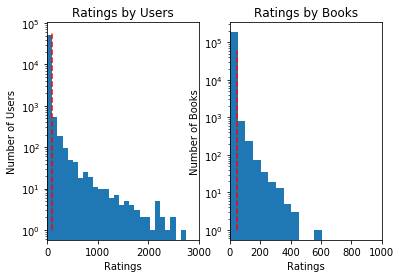

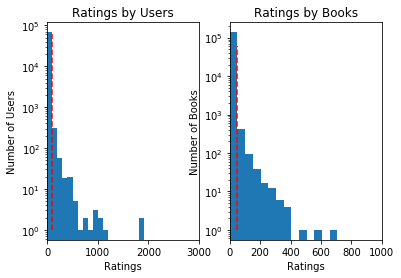

In [28]:
imp_small = reduceRates(imp, 100, 50)
exp_small = reduceRates(exp, 100, 50)

In [32]:
ratings_matrix_imp = makeMatrix(imp_small)
ratings_matrix_exp = makeMatrix(exp_small)

Matrix shape (1073, 1244)
Matrix shape (432, 626)


In [33]:
print(exp_small)

         User-ID        ISBN  Book-Rating
1456      277427  002542730X           10
1474      277427  0061009059            9
1522      277427  0316776963            8
1543      277427  0345413903           10
1578      277427  0385424736            9
...          ...         ...          ...
1146850   275970  0446391301            7
1146852   275970  044651652X            6
1147167   275970  0060987561            8
1147376   275970  0860074382           10
1147556   275970  0316776963            9

[10099 rows x 3 columns]


In [35]:
recs = recommendbook(11676, ratings_matrix_exp, 'exp', 4, 15)
for i, (rate, book) in enumerate(recs):
        bookTitle = findTitle(book)
        print("{} {} (expected rating {:0.2f})".format(i+1, bookTitle, rate))

1 Conspiracy.Com : A Novel (expected rating 6.45)
2 Pooh's Little Book of Feng Shui (expected rating 6.41)
3 Every Day's a Party : Louisiana Recipes For Celebrating With Family And Friends (expected rating 5.64)
4 The Guns of Avalon (Chronicles of Amber) (expected rating 5.62)
5 The Witness (expected rating 5.42)
6 Into the Wilderness (expected rating 5.30)
7 Witching Hour (Lives of the Mayfair Witches) (expected rating 4.97)
8 Curanderismo: Mexican American Folk Healing (expected rating -1.00)
9 Tales of Terror and the Supernatural (expected rating -1.00)
10 The Unbearable Lightness of Being (expected rating -1.00)


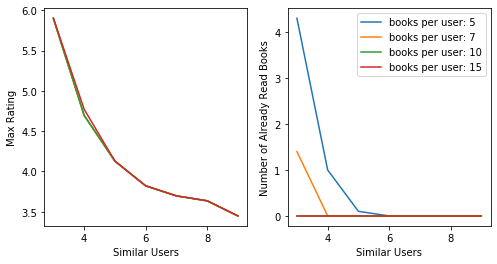

In [105]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))
n = 100

user_n = np.random.choice(ratings_matrix_exp.index, n, replace = False)
for i in [5, 7, 10, 15]:
    totaldiff = np.zeros(len(np.arange(3, 10)))
    totalmax = np.zeros(len(np.arange(3, 10)))
    for u in user100:
        diff = []
        maxrat = []
        for k in np.arange(3, 10):
            recs = recommendbook(u, ratings_matrix_exp, 'exp', k, i)
            rang = []
            for j, (rate, book) in enumerate(recs):
                rang.append(rate)
            maxrat.append(rang[0])
            diff.append(np.count_nonzero(np.array(rang)==-1))
            
                
        totaldiff = totaldiff + diff
        totalmax = totalmax + maxrat
        
     
    ax[1].plot(np.arange(3, 10), totaldiff/n*10, label = 'books per user: '+str(i))
    ax[1].set_xlabel('Similar Users')
    ax[1].set_ylabel('Number of Already Read Books')
    
    ax[0].plot(np.arange(3, 10), totalmax/n*10, label = 'books per user: '+str(i))
    ax[0].set_xlabel('Similar Users')
    ax[0].set_ylabel('Max Rating')
    ax[1].legend(loc = 1)

In [31]:
#for a given user,
#remove 10 books, 
#then try to recommend books for that user
#then check to see if any/all of those books where ones that were removed
def testUser(user_id, ratings_matrix, rateType):
    user_loc = ratings_matrix.index.get_loc(user_id)
    user_vec = ratings_matrix.iloc[user_loc, :]
    
    #find where user_vec == 0; 
    ratedBooks = np.where(user_vec != 0)
    print(len(ratedBooks[0]))
    
    #pick 10 at random to turn into 0
    removed = np.random.choice(ratedBooks[0], 100, replace=False)
    new_matrix = ratings_matrix.copy()
    new_matrix.iloc[user_loc, removed] = 0
    
    #isbns of removed books
    removedBooks = user_vec.index[removed]
        
    #recommend books
    print('\nRecommended Books:')
    recommended = recommendbook(user_id, ratings_matrix, rateType)
    
    print('\nLooking for removed books:')
    
    for i, (rate, book) in enumerate(recommended):
        if book in removedBooks:
            print('yay! found book: {}'.format(findTitle(book)))
    

In [33]:
testUser(11676, ratings_matrix_exp, 'exp')

329

Recommended Books:
1 White Oleander : A Novel (Oprah's Book Club) (expected rating 4.11)
2 1984 (expected rating 3.42)
3 Seven Up (A Stephanie Plum Novel) (expected rating 3.21)
4 Fahrenheit 451 (expected rating 3.18)
5 The Pilot's Wife : A Novel (expected rating 3.14)
6 Stupid White Men ...and Other Sorry Excuses for the State of the Nation! (expected rating 3.13)
7 The Clan of the Cave Bear (Earth's Children (Paperback)) (expected rating 3.04)
8 The Catcher in the Rye (expected rating 2.95)
9 Vinegar Hill (Oprah's Book Club (Paperback)) (expected rating 2.85)
10 Girl, Interrupted (expected rating 2.79)

Looking for removed books:


In [84]:
def addUser(bookIsbns, ratings_matrix):
    user_id = np.max(ratings_matrix.index)+1
    
    newuservec = np.zeros(len(ratings_matrix.columns))
    for isbn in bookIsbns:
        isbn_loc = ratings_matrix.columns.get_loc(isbn)
        newuservec[isbn_loc] = 1
    ratings_matrix.loc[user_id] = newuservec
    return ratings_matrix